In [ ]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [ ]:
#dataset load
df1 = pd.read_csv("diabetes.csv")
df = df1.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
#EDA
def check_df(dataframe, head=10):
    print('\033[1m' + 10*"*" + ' HEAD ' + 10*"*" + '\033[0m')
    print(dataframe.head())

    print('\033[1m' + 10*"*" + ' TAIL ' + 10*"*" + '\033[0m')
    print(dataframe.tail())

    print('\033[1m' + 10*"*" + ' SHAPE ' + 10*"*" + '\033[0m')
    print(dataframe.shape)

    print('\033[1m' + 10*"*" + ' TYPES ' + 10*"*" + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + 10*"*" + ' NUNIQUE ELEMENTS ' + 10*"*" + '\033[0m')
    print(dataframe.nunique())

    print('\033[1m' + 10*"*" + ' NA ' + 10*"*" + '\033[0m')
    print(dataframe.isnull().sum())

    print('\033[1m' + 10*"*" + ' DESCRIBE ' + 10*"*" + '\033[0m')
    print(dataframe.describe().T)

    print('\033[1m' + 10*"*" + ' DUPLICATED VALUE ' + 10*"*" + '\033[0m')
    print(dataframe.duplicated().sum())


check_df(df,10)

********** HEAD **********
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1
********** TAIL **********
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.900                     0.171   63        0
764            2      122             70             27       

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

       It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
            df: Dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                threshold value for numeric but categorical variables
        car_th: int, optinal
                threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical but cardinal variable list

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [ ]:
cat_cols

['Outcome']

In [ ]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

   Outcome  Ratio
0      500 65.104
1      268 34.896
##################### Outcome ############################


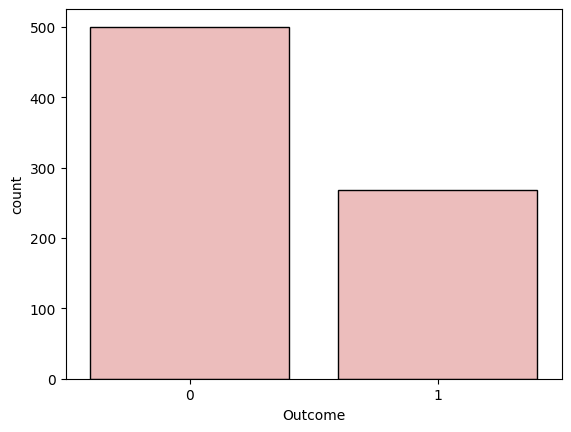

In [ ]:
#CATEGORICAL VARIABLE ANALYSIS

def cat_summary( dataframe, col_name, plot = False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       'Ratio':100 * dataframe[col_name].value_counts()/len(dataframe)}))

    print('#####################',col_name,'############################')

    if plot:
        sns.countplot(x = dataframe[col_name], data = dataframe, edgecolor='black', color='#F4B5B4')
        plt.show(block = True)

for col in cat_cols:
    cat_summary(df, col, plot = True)



    ## We have seen that the behaviors of those with diabetes are around 35%, while those without diabetes are around 65%.

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


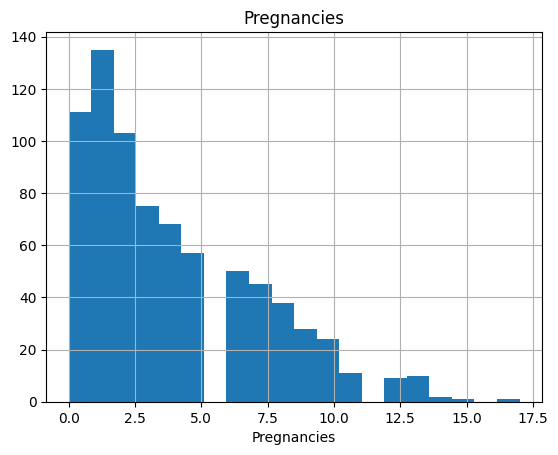

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


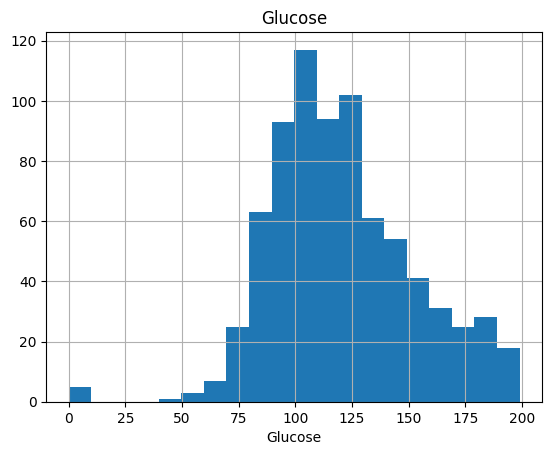

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


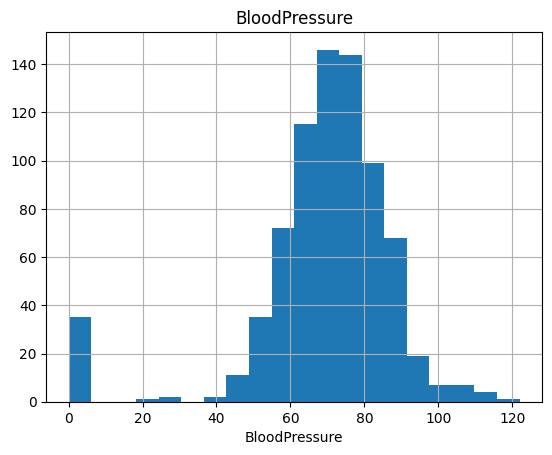

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


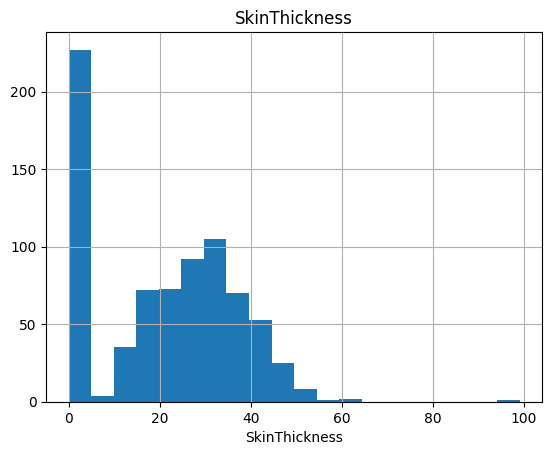

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


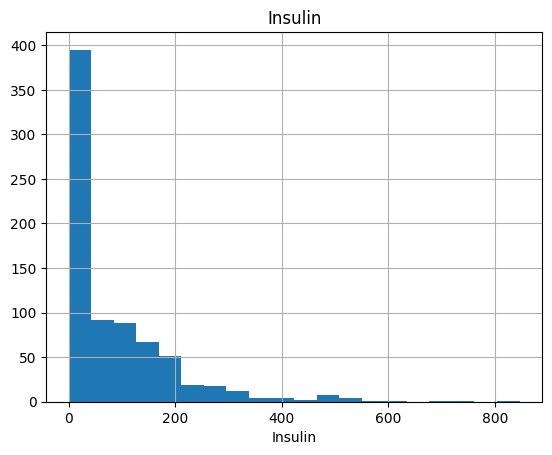

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


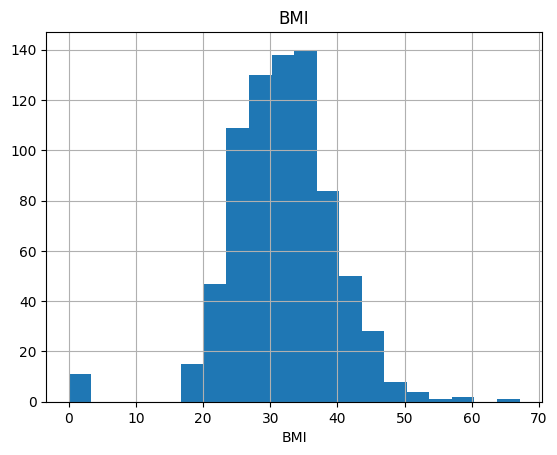

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


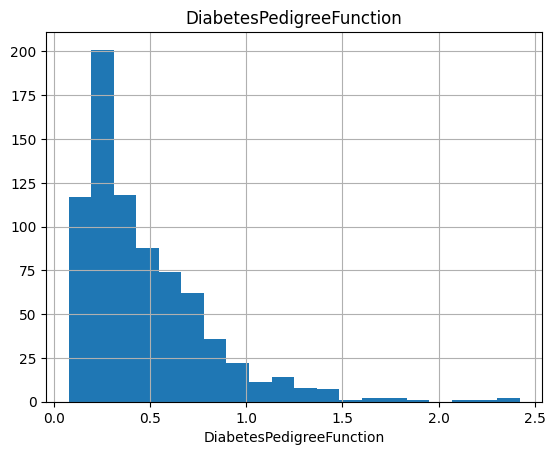

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


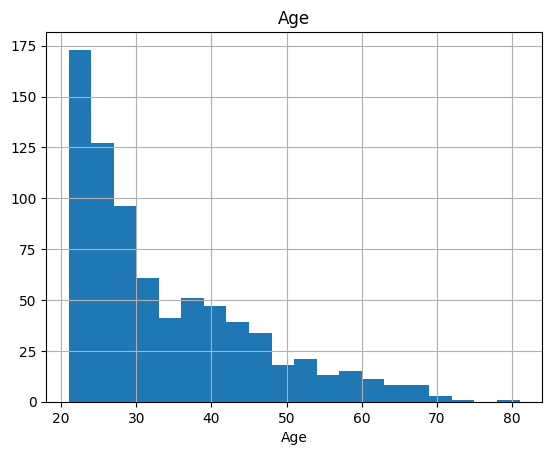

In [ ]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

In [ ]:
#Analysis of Target Variable
#Let's observe the values that represent our target variable, 'Outcome', that is, diabetes, with the average of other numerical variables.
def target_summary_with_num(dataframe,target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col:"mean"}), end="\n\n")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

for col in num_cols:
    target_summary_with_num(df,"Outcome",col)

         Pregnancies
Outcome             
0              3.298
1              4.866

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         Glucose
Outcome         
0        109.980
1        141.257

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         BloodPressure
Outcome               
0               68.184
1               70.825

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         SkinThickness
Outcome               
0               19.664
1               22.164

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         Insulin
Outcome         
0         68.792
1        100.336

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           BMI
Outcome       
0       30.304
1       35.143

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
           Age
Outcome       
0       31.190
1       37.067

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
#mISSING VALUES
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
missing_values = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[missing_values] = df[missing_values].replace(0,np.NaN)

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


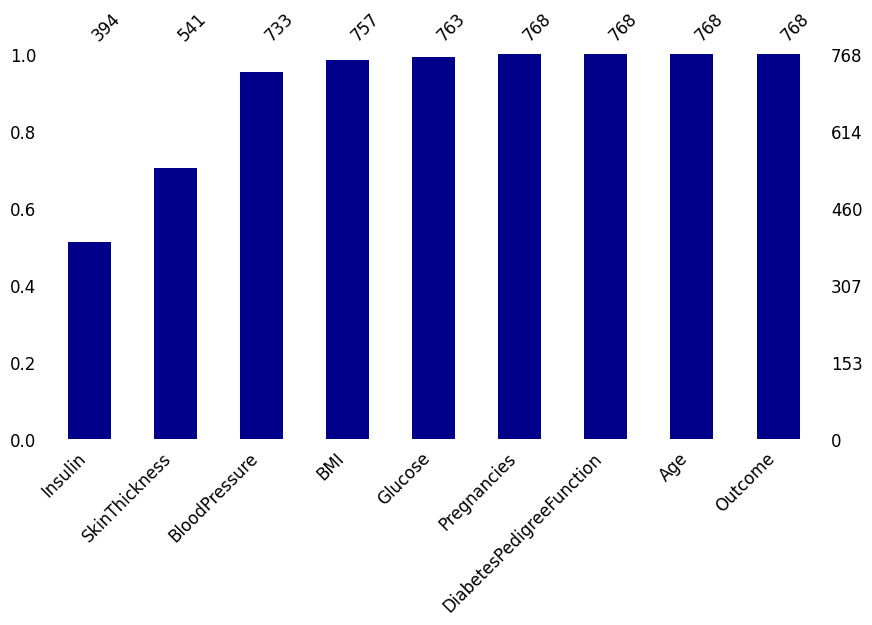

In [ ]:
#When we filled the values with 0 with NaN, we were able to see the missing values that we could not see at first.

#Let's see these missing values better with the help of graphs and heatmap.
msno.bar(df, color="darkblue", sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

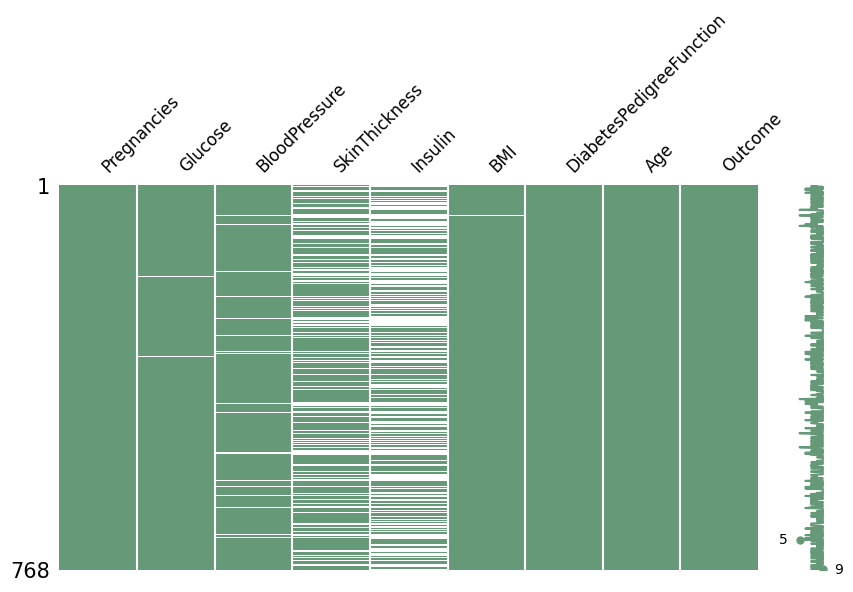

In [ ]:
msno.matrix(df,figsize=(10,5), fontsize=12, color=(0.4, 0.6, 0.47))
plt.show()
#The white horizontal lines represent the shortcomings.



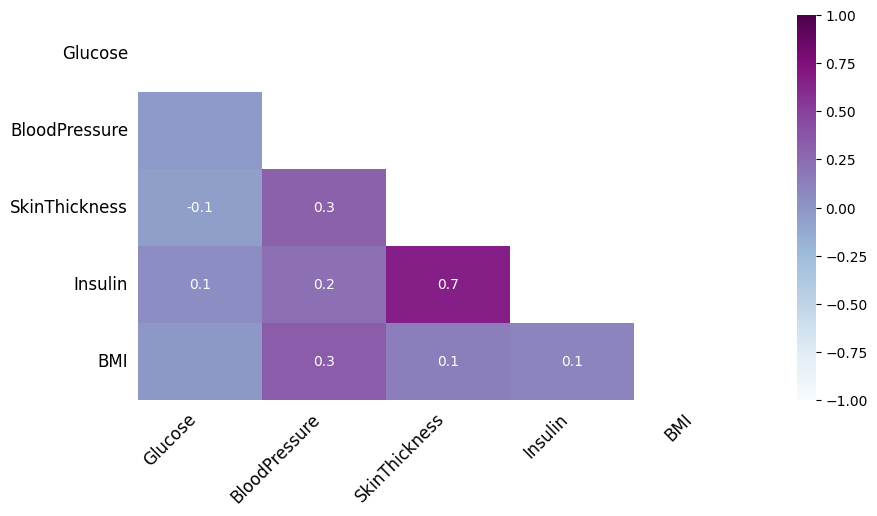

In [ ]:
msno.heatmap(df,cmap="BuPu",figsize=(10,5), fontsize=12)
plt.show()
#We observed a high correlation between insulin and skin thickness.

In [ ]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

na_columns = missing_values_table(df, True)

missing_vs_target(df, "Outcome", na_columns)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650
                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [ ]:
# Let's fill in the missing values with the median.
df = df.fillna(df.groupby('Outcome').transform('median'))

# Now let's look at the number of missing values.
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# @title Default title text
#outlier analysis Without reducing our data too much, let's determine the lower and upper threshold values for outliers.

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [ ]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [ ]:
#def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [ ]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [ ]:
for col in num_cols:
    print(col, check_outlier(df, col))


Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


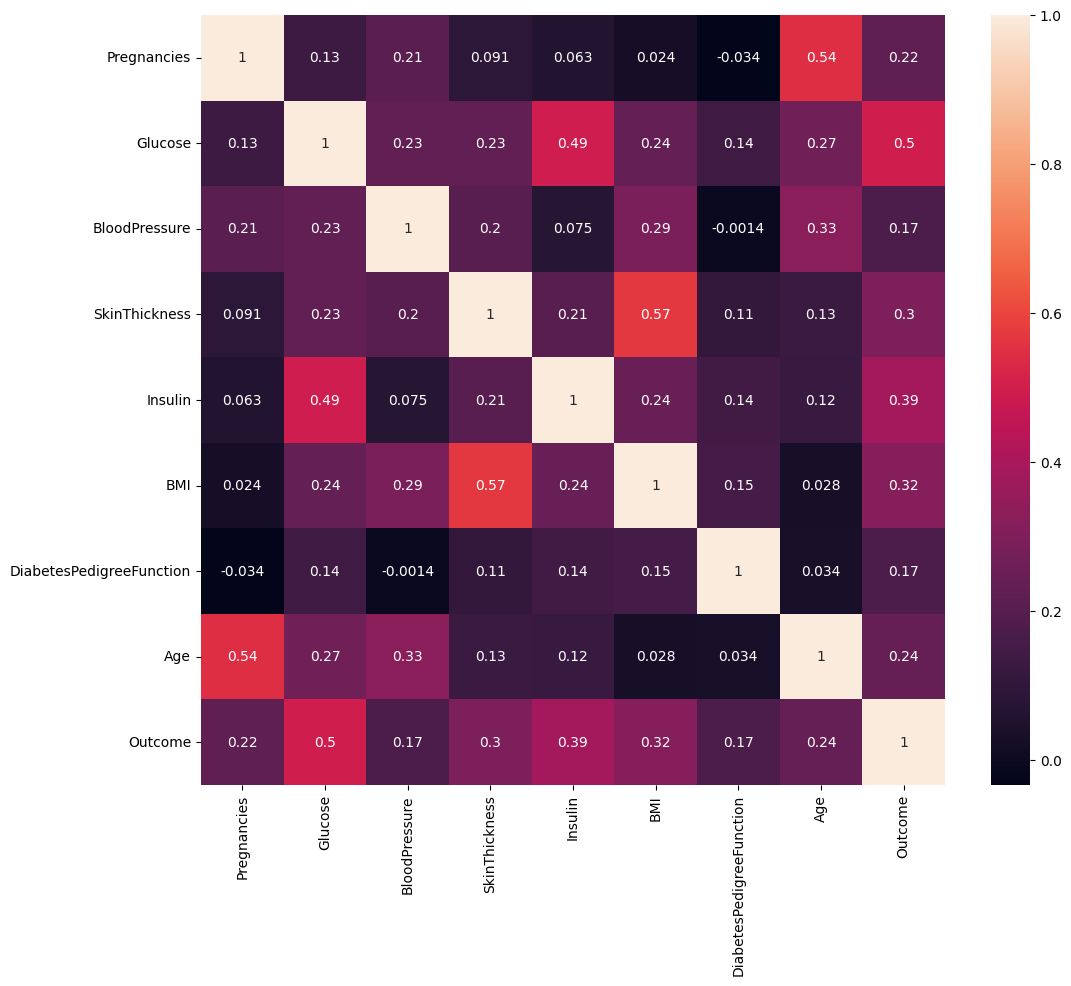

In [ ]:
#CORRELATION
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True);

We were able to see the correlation between the two variables more clearly with the heat map. For example, there is a positive correlation between skin thickness and body mass index.There is also a 0.5 correlation between glucose and outcome.

Feature Extraction
Let's derive new variables to increase our model success.

In [ ]:
df["Age_CAT"] = pd.qcut(df['Age'], 3, labels=["young","mature","old"])


df.loc[(df["Pregnancies"] == 0), 'Preg_CAT']  = 'Never'
df.loc[(df["Pregnancies"] == 1), 'Preg_CAT']  = 'One_Time'
df.loc[(df["Pregnancies"] > 1), 'Preg_CAT']   = 'Many_Times'


df.loc[(df["Glucose"] < 70), 'GLUCOSE_CAT'] ="Hipoglisemi"
df.loc[(df["Glucose"] >= 70) & (df['Glucose'] < 100) , 'GLUCOSE_CAT'] ="Normal"
df.loc[(df["Glucose"] >= 100) & (df['Glucose'] < 125) , 'GLUCOSE_CAT'] ="Imparied_Glucose"
df.loc[(df["Glucose"] >= 125), 'GLUCOSE_CAT'] ="Hiperglisemi"


df["BMI_CAT"] = pd.cut(df["BMI"], bins= [0, 18.5, 24.9, 29.9, 34.9, 39.9, 49.9],
                    labels=["underweight", "normal", "overweight", "obese", "obese_class2", "obese_class3" ])


df["AGE_BMI"] = df["Age"] * df["BMI"]

df["PREG_SKIN"] = df["Pregnancies"] * df["SkinThickness"]

df["PREG_BMI"] = df["Pregnancies"] * df["BMI"]

df["GLU_INS"] = df["Glucose"] * df["Insulin"]


df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_CAT,Preg_CAT,GLUCOSE_CAT,BMI_CAT,AGE_BMI,PREG_SKIN,PREG_BMI,GLU_INS
0,6,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,old,Many_Times,Hiperglisemi,obese,1680.000,210.000,201.600,25086.000
1,1,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,mature,One_Time,Normal,overweight,824.600,29.000,26.600,8712.500
2,8,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,mature,Many_Times,Hiperglisemi,normal,745.600,256.000,186.400,31018.500
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,young,One_Time,Normal,overweight,590.100,23.000,28.100,8366.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Never,Hiperglisemi,obese_class3,1422.300,0.000,0.000,23016.000


In [ ]:
df.shape

(768, 17)

Encoding
We will change the representation of our variables with encoding. We will convert them to machine language values 0 and 1.

In [ ]:
# Label Encoding

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"] and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

In [ ]:
# One Hot Encoding

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AGE_BMI,PREG_SKIN,PREG_BMI,GLU_INS,Age_CAT_mature,Age_CAT_old,Preg_CAT_Never,Preg_CAT_One_Time,GLUCOSE_CAT_Hipoglisemi,GLUCOSE_CAT_Imparied_Glucose,GLUCOSE_CAT_Normal,BMI_CAT_normal,BMI_CAT_overweight,BMI_CAT_obese,BMI_CAT_obese_class2,BMI_CAT_obese_class3
0,6,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1,1680.000,210.000,201.600,25086.000,0,1,0,0,0,0,0,0,0,1,0,0
1,1,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0,824.600,29.000,26.600,8712.500,1,0,0,1,0,0,1,0,1,0,0,0
2,8,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1,745.600,256.000,186.400,31018.500,1,0,0,0,0,0,0,1,0,0,0,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,590.100,23.000,28.100,8366.000,0,0,0,1,0,0,1,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,1422.300,0.000,0.000,23016.000,1,0,1,0,0,0,0,0,0,0,0,1


Feature Scaling
We need to scale in order to eliminate the measurement difference between variables and to evaluate all variables under equal conditions.

In [ ]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Modelling
We divide our dataset into two as test and train.

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

We will make 3 different models and evaluate the model success.

Random Forest Classifier
Logistic Regression
XGBoost

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
rfc_acc = accuracy_score(y_test, rfc_pred)
print('RandomForestClassifier accuracy:', rfc_acc)

RandomForestClassifier accuracy: 0.8831168831168831


In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000,random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print('LogisticRegression accuracy:', lr_acc)

LogisticRegression accuracy: 0.7792207792207793


In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train)
xgb_acc = xgb_model.score(X_test, y_test)
print('XGBClassifier accuracy:', xgb_acc)

XGBClassifier accuracy: 0.8961038961038961


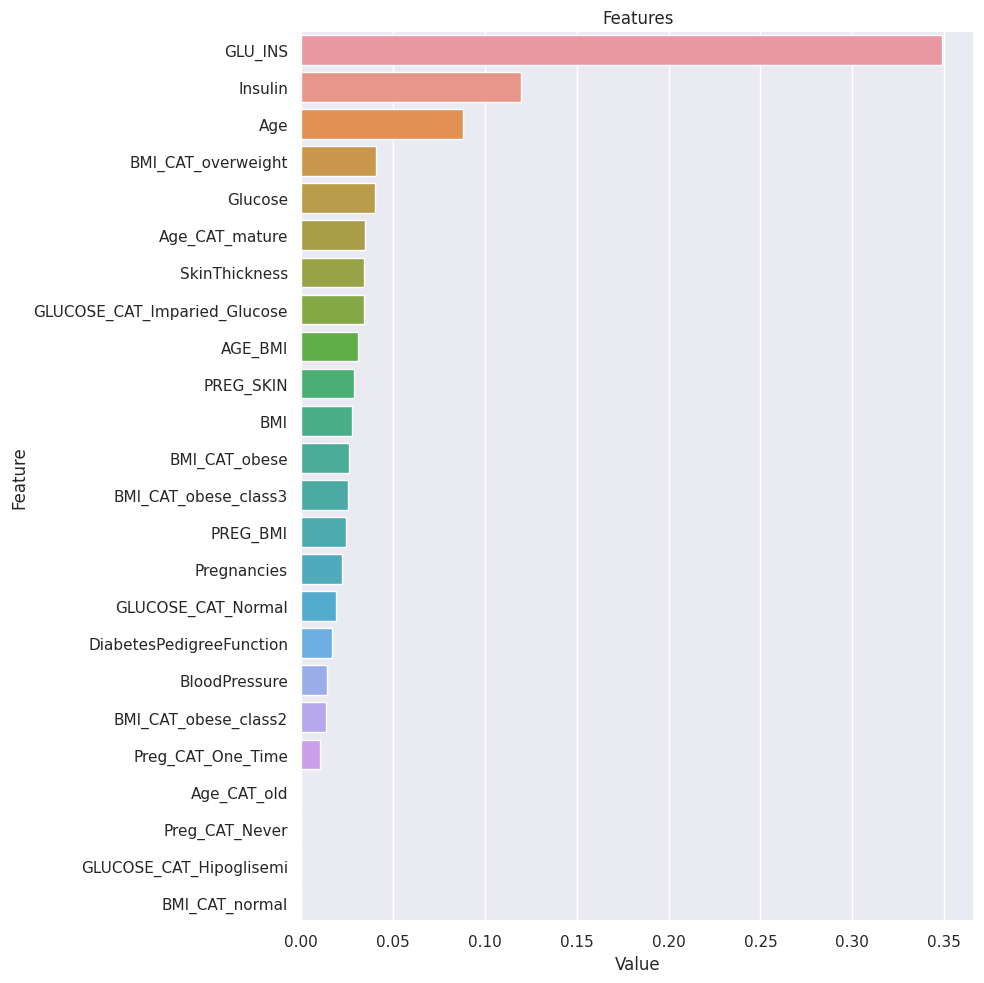

In [ ]:
#Let's observe the most important variables that affect our model success.

def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (10, 10))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(xgb_model, X_train)

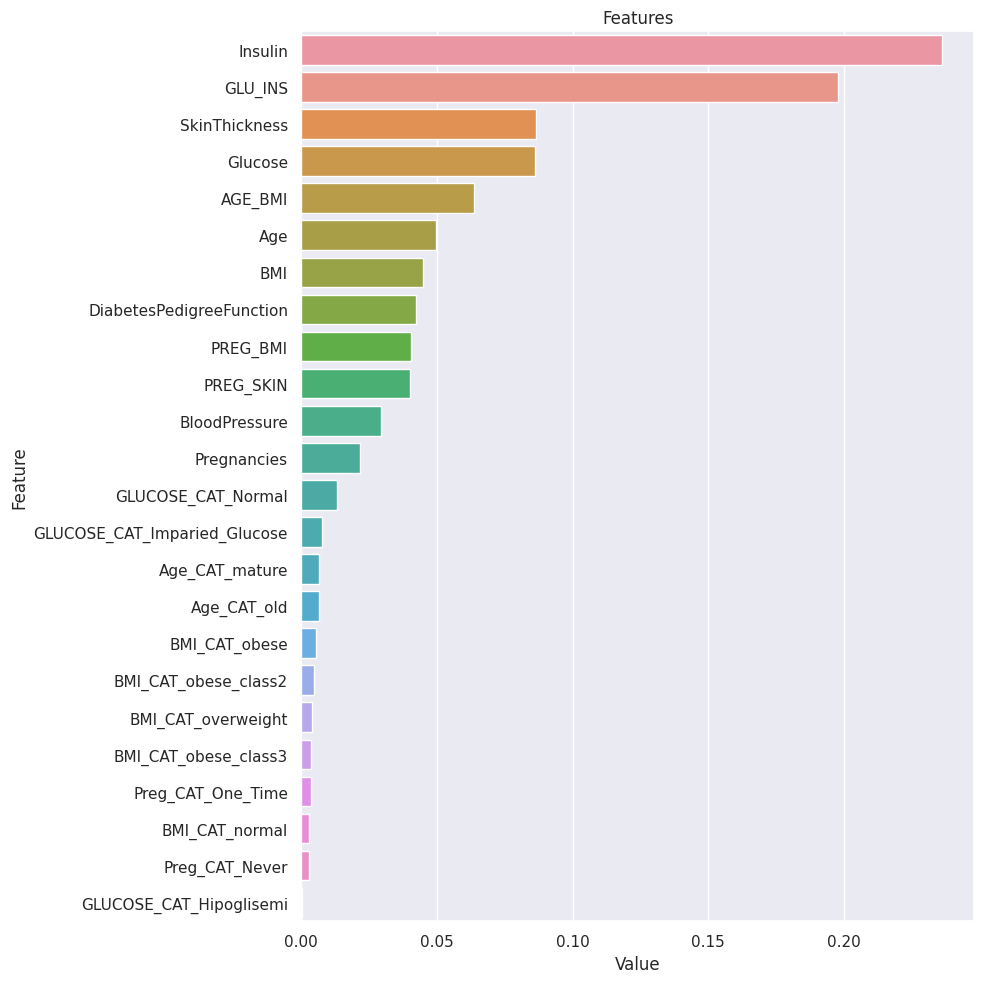

In [ ]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (10, 10))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(rfc, X_train)


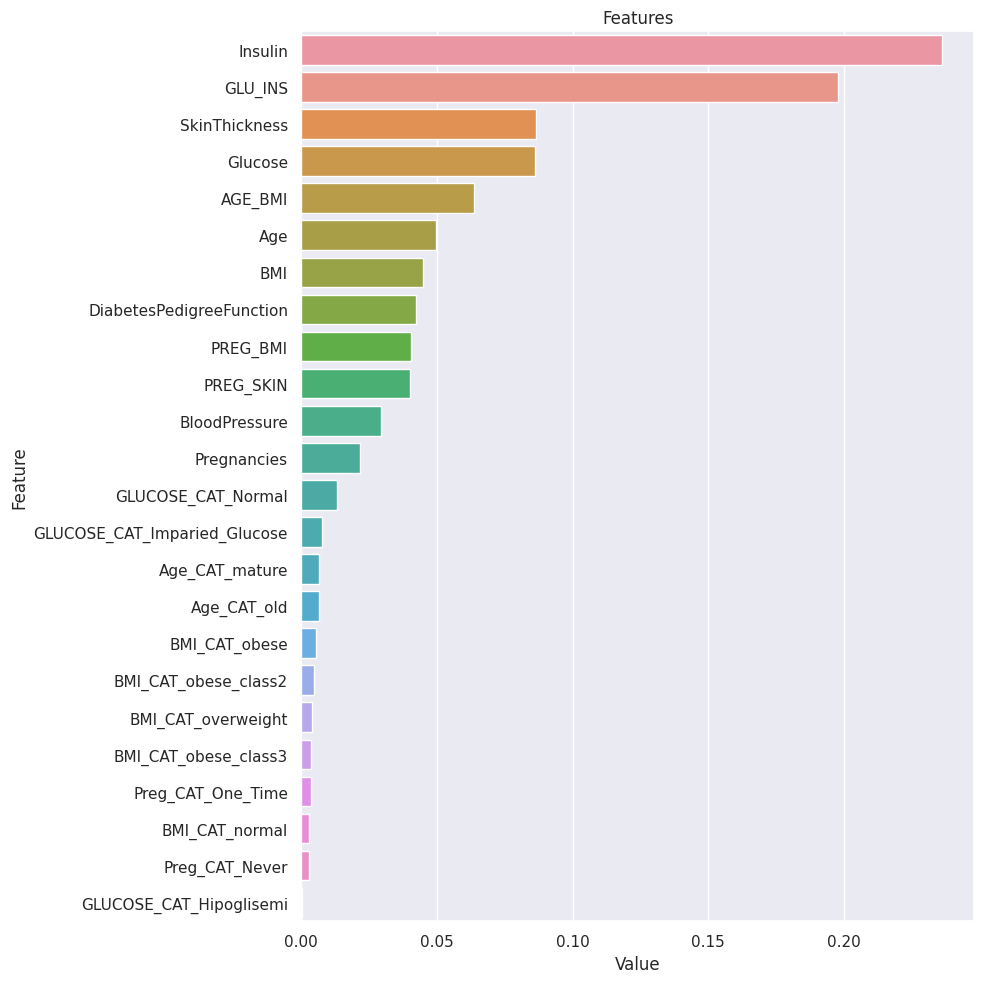

In [ ]:
def plot_importance(model, features, num=len(X)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize = (10, 10))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value", y = "Feature", data = feature_imp.sort_values(by = "Value", ascending = False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)

plot_importance(rfc, X_train)
